# Imports

For this notebook we need to import the pathlib Path object and everything from the fastai.vision.all module. Note, while ``import *`` is usually considered bad form, the fastai library is designed to behave well with importing everything.

In [1]:
from pathlib import Path
from fastai.vision.all import *

# Load data

First we need to load the image data using [fastai](https://docs.fast.ai/). For the simple case we're looking at here, we could use the ready-made [ImageDataLoaders](https://docs.fast.ai/vision.data.html#ImageDataLoaders), but below we'll demonstrate how to use the more flexible [DataBlock API](https://docs.fast.ai/tutorial.datablock.html).

Before we go on, we should mention how the data is organized on disk, since this motivates some of the choices below. The data is contained in a folder with the following structure:

 - train (training data)
   - pos (positive - signature containing)
     - [... image files]
   - neg (negative - signature missing)
     - [... image files]
 - test (test/validation data)
   - pos
     - [... image files]
   - neg
     - [... image files]

The is defined by a list of **blocks**, the last of which is assumed to be a label/model output. **get_items** defines a function that generates a list of items that are fed to the blocks: the *get_image_files* returns a list of paths to image files in the given directory. **get_y** defines a function, that takes an item and transforms it into the label: the *parent_label* function takes an item/path and returns the name of the parent directory. **splitter** defines a function used to split the data into training and validation sets: *GrandParentSplitter* returns a function that looks at the granparent directory of each item/path and marks all files in subdirectories of *valid_name* validation data. Finally **item_tfms** can take a list of transformations that are run on each item: *Resize* resize the images into the given size using the given method (squish means that aspect ratio is not respected and the image is warped to fit the given size).

Once the DataBlock is defined, we can derive a Dataloader that will actually load the data according to the blueprint defined in the DataBlock. The input we give the **dataloaders** method is simply the path to the images, which is fed into the **get_items** function of the DataBlock:

In [6]:
data_path = Path('../data/tmp/')

db = DataBlock(blocks=(ImageBlock, CategoryBlock),
               get_items=get_image_files,
               get_y=parent_label,
               splitter=GrandparentSplitter(valid_name='test'),
               item_tfms=Resize(size=(414,585), method='squish'))

dls = db.dataloaders(data_path)

Now that we have a dataloader, we can use it to show an example batch of items/images:

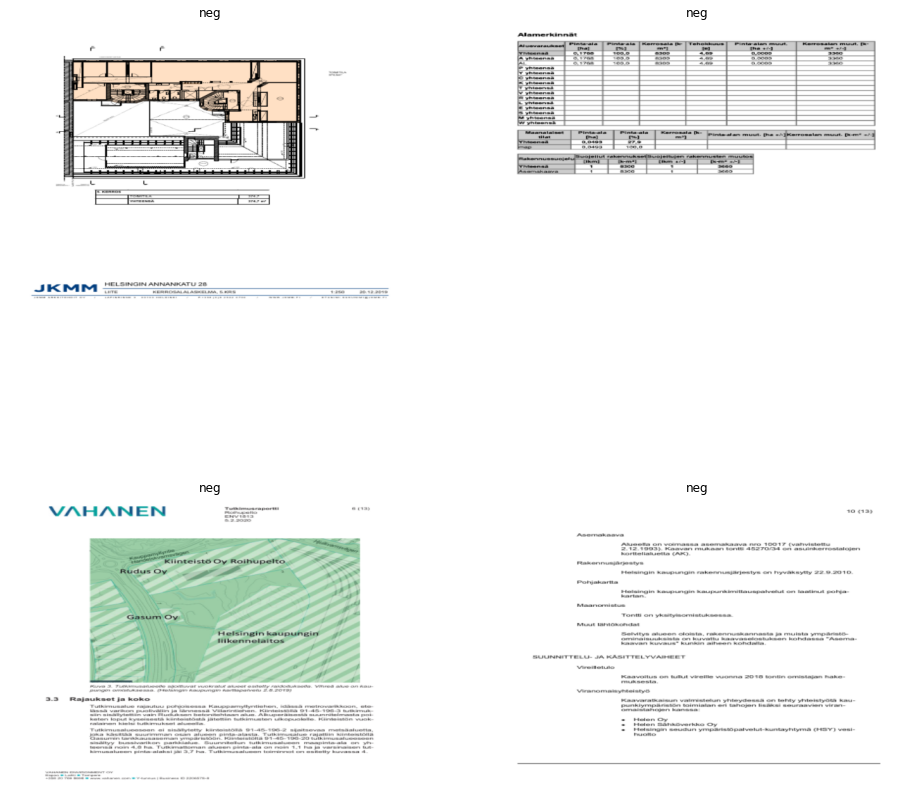

In [3]:
dls.show_batch(max_n=4, figsize=(16,16))

# Create learner

With the data loaded we can create the model and a learner for the model. We will use a convolutional neural network (CNN) as the model. Specifically we will finetune a pretrained CNN following the  [Resnet18](https://pytorch.org/hub/pytorch_vision_resnet/) architecture (**arch**). The model has been pretrained on the [Imagenet](http://www.image-net.org/about-overview) dataset: this dataset roughly a million photographs of 1000 different classes of objects or animals. Even though the network has been trained with images unlike our target images, we will see that the network performs admirably after fine-tuning. During training we will use the specified **metrics**, error rate and recall to monitor the performance. Note that the metrics are distinct from the actual loss function being optimized: the metrics are only there for monitoring performance.

Once we have the learner and model, we can print out a summary of the model, which includes information about the model layers, number of parameters, which layers will be trained, etc. Note that the dataloader has a predefined batch size, which can be customized, if necessary:

In [5]:
learner = cnn_learner(dls, arch=resnet18, metrics=[error_rate, Recall()])
learner.summary()

Sequential (Input shape: ['64 x 3 x 414 x 585'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 207 x 293  9,408      False     
________________________________________________________________
BatchNorm2d          64 x 64 x 207 x 293  128        True      
________________________________________________________________
ReLU                 64 x 64 x 207 x 293  0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 104 x 147  0          False     
________________________________________________________________
Conv2d               64 x 64 x 104 x 147  36,864     False     
________________________________________________________________
BatchNorm2d          64 x 64 x 104 x 147  128        True      
________________________________________________________________
ReLU                 64 x 64 x 104 x 147  0          False     
_________________________________________________

We can see that the chosen model has ~12 000 000 parameters in total and the first stage of finetuning the model will train ~500 000 of these.

# Find the optimal learning rate

One of the tunable hyperparameters in training a neural network is the learning rate. During teaching, the model parameters (or weights) are adjusted iteratively so as to improve classification performance. The learning rate defines how big the changes to the parameters are during each iteration. A very high learning rate risks overshooting the target and leads to unstable learning. A very low learning rate is stable, but the learning will take too long. Luckily fastai offers a method for finding a good learning rate.

The learning rate finder tries out different learning rates and observes the loss (see Training below). A good learning rate is often at either the point of steepest descent of loss (**lr_steep**), or one order of magnitude below the curve minimum (**lr_min**). The generated curve can sometimes be noisy, which can throw off the steepest descent of loss estimate, so using *lr_min* is often more reasonable.

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=7.585775847473997e-07)

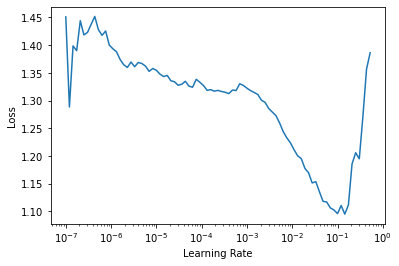

In [26]:
learner = cnn_learner(dls, resnet18, metrics=[error_rate, Recall()])
learner.lr_find()

# Train

Now we are ready to train the model. During training the model is shown and asked to classify the examples in the training data. The model is then scored on its performance in terms of the **loss**. The loss is a surrogate performance measure for our measure of interest, classification accuracy. The loss has two benefits in comparison to straight up classification accuracy: (1) it takes into account the confidence of the model (a confident wrong answer is worse and an inconfident one), (2) it changes smoothly as a function of the model parameters (this is important for the optimization process).

During fine-tuning the final layers of the model are first trained for a number of **epochs** (1 epoch = 1 pass through the training data), this stage defaults to 1 epoch. Afterwards, the entire model is trained for a specified number of epochs using the given learning rate (**base_lr**) and in this case some callbacks (**cbs**). The callbacks are used here to show a graph of the training progress (**ShowGraphCallback**) and saving the model, when validation loss improves (**SaveModelCallback**).

The graphs visualize how the loss (y-axis) develops as a function of the training batch (x-axis). Note: we are usually interested in the validation loss (orange line):

epoch,train_loss,valid_loss,error_rate,recall_score,time
0,1.250288,0.626155,0.200000,0.363636,00:06


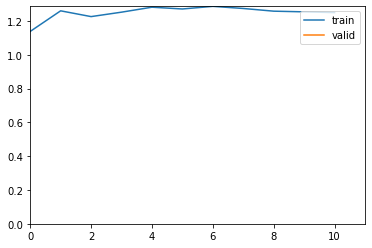

Better model found at epoch 0 with valid_loss value: 0.6261545419692993.


epoch,train_loss,valid_loss,error_rate,recall_score,time
0,0.882017,0.466752,0.209091,0.454545,00:08
1,0.663260,0.372014,0.118182,0.454545,00:08
2,0.536554,0.384354,0.145455,0.363636,00:08
3,0.451376,0.291996,0.072727,0.545455,00:08
4,0.374060,0.233788,0.063636,0.545455,00:08
5,0.298993,0.291572,0.063636,0.454545,00:08
6,0.258633,0.283410,0.090909,0.363636,00:08
7,0.212649,0.213071,0.027273,0.727273,00:08
8,0.185161,0.427050,0.072727,0.454545,00:08
9,0.170301,0.392857,0.081818,0.181818,00:08


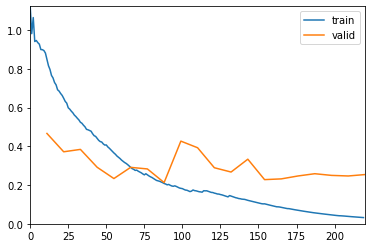

Better model found at epoch 0 with valid_loss value: 0.46675220131874084.
Better model found at epoch 1 with valid_loss value: 0.37201398611068726.
Better model found at epoch 3 with valid_loss value: 0.29199570417404175.
Better model found at epoch 4 with valid_loss value: 0.23378802835941315.
Better model found at epoch 7 with valid_loss value: 0.21307088434696198.


In [27]:
cbs = [ShowGraphCallback(), SaveModelCallback(fname='naive_model')]
learner.fine_tune(epochs=20, base_lr=1e-2, cbs=cbs)

# Evaluate

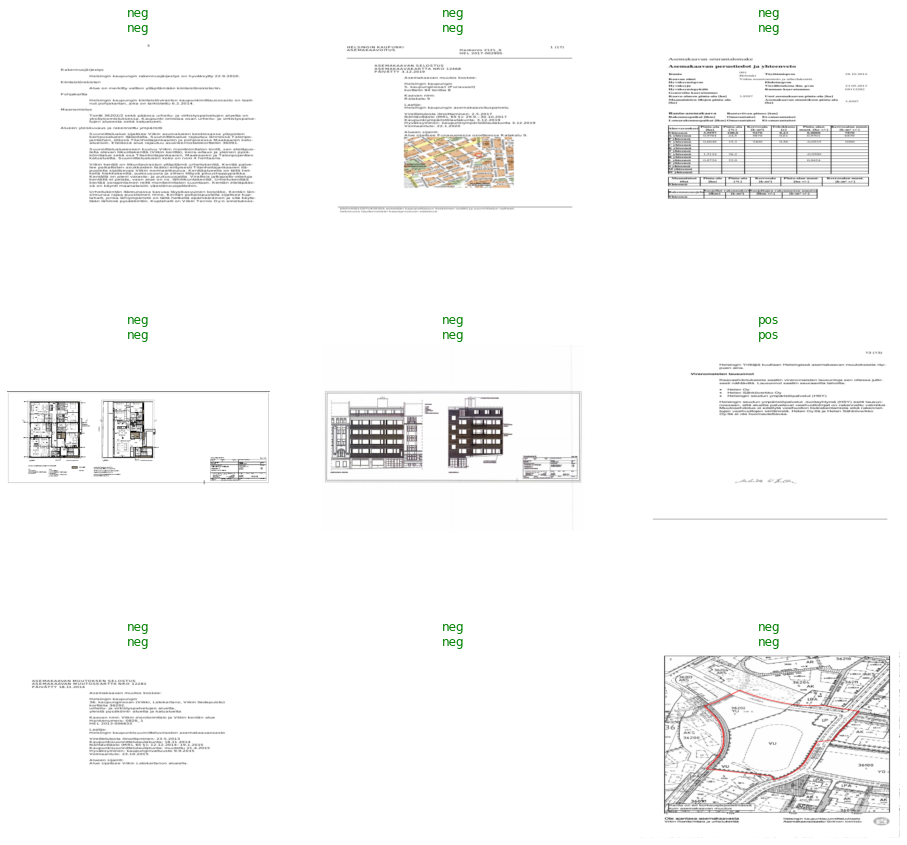

In [34]:
learner = learner.load('naive_model')
learner.show_results(figsize=(16,16))

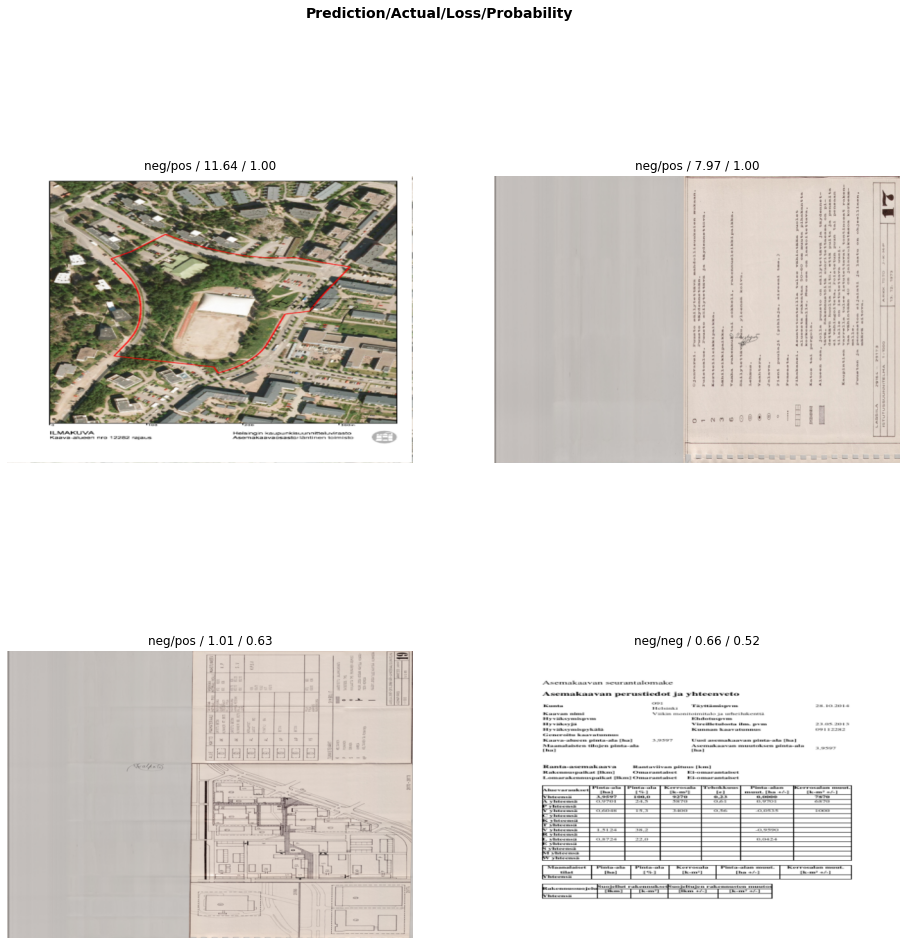

In [30]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_top_losses(4, figsize=(16,16))

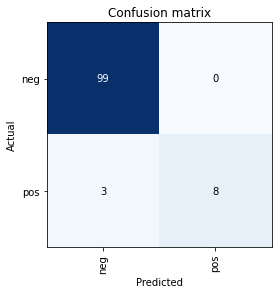

In [31]:
interp.plot_confusion_matrix()